In [47]:
import imp
import os
import cv2
import pdb
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
from torch import optim
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.functional import InterpolationMode
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import logging
import datetime
import sys
import cv2
import matplotlib.pyplot as plt
import PIL

In [77]:
import torchviz
from pytorchvideo.data import LabeledVideoDataset, make_clip_sampler

In [49]:
gloss_df_path = "data_validation/processed_gloss.csv"
gloss_df = pd.read_csv(gloss_df_path)
gloss_df.dropna(inplace=True)

In [50]:
gloss_df.replace(to_replace="ASHAG", value="AŞAĞI", inplace=True)

In [51]:
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70


In [52]:
gloss_df['glossRange'] = gloss_df['glossEnd'] - gloss_df['glossStart']
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0


In [53]:
gloss_df.glossRange.mean()

21.5597629239381

In [54]:
def img_resize(img_path, dims=(256, 256)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=dims)

    return img

In [55]:
gloss_df[pd.isnull(gloss_df['glossStart'])]

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange


In [56]:
num_classes = len(gloss_df.gloss.unique())
num_classes

234

In [57]:
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights
from torchvision import transforms

In [58]:
# Image normalization transforms.
def normalize_transform(pretrained):
    if pretrained: # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    else: # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize
    
def get_train_transform(dims, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize(dims),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform

def get_valid_transform(IMAGE_SIZE, pretrained):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform


In [59]:
weights = SqueezeNet1_1_Weights.IMAGENET1K_V1
model = squeezenet1_1(weights=weights)

In [60]:
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [61]:
list(model.children())[:-1]

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
   (3): Fire(
     (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
     (squeeze_activation): ReLU(inplace=True)
     (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
     (expand1x1_activation): ReLU(inplace=True)
     (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (expand3x3_activation): ReLU(inplace=True)
   )
   (4): Fire(
     (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
     (squeeze_activation): ReLU(inplace=True)
     (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
     (expand1x1_activation): ReLU(inplace=True)
     (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (expand3x3_activation): ReLU(inplace=True)
   )
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation

In [62]:
preprocess = weights.transforms()

In [63]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [64]:
from typing import Optional, Tuple

In [65]:
# class ImageClassification(nn.Module):
#     def __init__(
#         self,
#         *,
#         crop_size: int,
#         resize_size: int = 256,
#         mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
#         std: Tuple[float, ...] = (0.229, 0.224, 0.225),
#         # interpolation: InterpolationMode = InterpolationMode.BILINEAR,
#     ) -> None:
#         super().__init__()
#         self.crop_size = [crop_size]
#         self.resize_size = [resize_size]
#         self.mean = list(mean)
#         self.std = list(std)
#         # self.interpolation = interpolation

#     def forward(self, img: Tensor) -> Tensor:
#         # img = F.resize(img, self.resize_size)
#         img = F.center_crop(img, self.crop_size)
#         if not isinstance(img, Tensor):
#             img = F.pil_to_tensor(img)
#         img = F.convert_image_dtype(img, torch.float)
#         # img = F.normalize(img, mean=self.mean, std=self.std)
#         return img

#     def __repr__(self) -> str:
#         format_string = self.__class__.__name__ + "("
#         format_string += f"\n    crop_size={self.crop_size}"
#         format_string += f"\n    resize_size={self.resize_size}"
#         format_string += f"\n    mean={self.mean}"
#         format_string += f"\n    std={self.std}"
#         # format_string += f"\n    interpolation={self.interpolation}"
#         format_string += "\n)"
#         return format_string

#     def describe(self) -> str:
#         return (
#             "Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. "
#             f"The images are resized to ``resize_size={self.resize_size}`` using ``interpolation={self.interpolation}``, "
#             f"followed by a central crop of ``crop_size={self.crop_size}``. Finally the values are first rescaled to "
#             f"``[0.0, 1.0]`` and then normalized using ``mean={self.mean}`` and ``std={self.std}``."
#         )


In [66]:
# from functools import partial
# transforms=ImageClassification(crop_size=224, resize_size=232)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'> (960, 1280, 3)
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


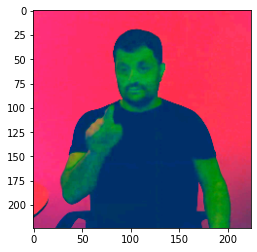

In [67]:
file_path = "../data/cam2/1/2022-04-25 13-29-56.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
print(type(img), img.shape)
img = PIL.Image.fromarray(img)
# img = transforms.forward(img)
img = preprocess.forward(img)
print(type(img))

print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [68]:
# arch = list(model.children())[:-1][0]
# classifier_2d = list(model.children())[-1][:-2]
# classifier_2d

# modules = [layer for layer in arch]
# modules += [layer for layer in classifier_2d]
# modules.append(nn.AdaptiveAvgPool2d(output_size=(13, 512)))
# my_model = nn.Sequential(*modules)
# my_model

In [69]:
# file_path = "../data/cam2/1/2022-04-25 13-29-56.mp4"

# cap = cv2.VideoCapture(file_path)
# cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
# res, img = cap.read()
# img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
# img = PIL.Image.fromarray(img)
# img = preprocess.forward(img)

# dims = [1]
# dims = dims + list(img.shape)
# print(dims)
# img = torch.reshape(img, dims)
# # print(img.shape)
# out = my_model(img)
# out.shape

In [70]:
def frame_preprocess(img):
    """
    In:
    - img (numpy.ndarray): input image of shape [height, width, num_channels]
    Out:
    - (torch.Tensor): output Tensor of shape [num_channels, height, width]
    """

    img = PIL.Image.fromarray(img)
    preprocess = weights.transforms()
    img = preprocess.forward(img)

    return img

# Model Development

In [71]:
model = squeezenet1_1(weights=weights)
modules = list(model.children())[:-1]

# arch = list(model.children())[:-1][0]
# classifier_2d = list(model.children())[-1][:-2]
# classifier_2d

# modules = [layer for layer in arch]
# # modules += [layer for layer in classifier_2d]
# # modules.append(nn.AdaptiveAvgPool2d(output_size=(13, 1)))
my_model = nn.Sequential(*modules)
# my_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel

In [72]:
# file_path = "../dwillata/gloss/1/2022-08-01 13-56-29.mp4"


# # TO-DO: optimize conversion

# cap = cv2.VideoCapture(file_path)
# batch = []
# # ret = True
# flat_ft_size = 25
# pad_dims = [3, 224, 224]
# count = 0

# video_vf = torch.Tensor().to(device)


# while cap.isOpened():
#     ret, frame = cap.read()
    
#     if ret:
#         batch.append(frame_preprocess(frame))

#     count += 1
    
#     if len(batch) == flat_ft_size:
#         batch = torch.stack(batch)
#         batch = batch.to(device)
#         flat_vf = my_model(batch)
#         # flat_vf, _ = torch.max(flat_vf, dim=0)
#         print(flat_vf.shape)
#         flat_vf = flat_vf.reshape([1]+list(flat_vf.shape))
#         video_vf = torch.cat((video_vf, flat_vf))

#         batch = []
    
#     if not ret:
#         if len(batch) != flat_ft_size and batch:
#             batch = torch.stack(batch)
#             padding = torch.zeros([flat_ft_size - len(batch)] + pad_dims)            
            
#             batch = torch.vstack((batch, padding))
#             batch = batch.to(device)
#             flat_vf = my_model(batch)
#             # flat_vf, _ = torch.max(flat_vf, dim=0)
#             flat_vf = flat_vf.reshape([1]+list(flat_vf.shape))
#             print(video_vf.shape)
#             print(flat_vf.shape)
#             video_vf = torch.cat((video_vf, flat_vf))

#         break


# video_vf.shape

In [73]:
def extract_video_features(file_path, model, device, flat_ft_size=25, pad_dims = [3, 224, 224]):
    cap = cv2.VideoCapture(file_path)
    batch = []

    video_vf = torch.Tensor().to(device)


    while cap.isOpened():
        ret, frame = cap.read()
        
        if ret:
            batch.append(frame_preprocess(frame))
    
        if len(batch) == flat_ft_size:
            batch = torch.stack(batch)
            batch = batch.to(device)
            flat_vf = model(batch)
            # flat_vf, _ = torch.max(flat_vf, dim=0)
            flat_vf = flat_vf.reshape([1]+list(flat_vf.shape))
            video_vf = torch.cat((video_vf, flat_vf))

            batch = []
            
        if not ret:

            if len(batch) != flat_ft_size and batch:
                batch = torch.stack(batch)
                padding = torch.zeros([flat_ft_size - len(batch)] + pad_dims)            
                
                batch = torch.vstack((batch, padding))
                batch = batch.to(device)
                flat_vf = model(batch)
                # flat_vf, _ = torch.max(flat_vf, dim=0)
                flat_vf = flat_vf.reshape([1]+list(flat_vf.shape))
     
                video_vf = torch.cat((video_vf, flat_vf))

            break


    return video_vf

In [74]:
file_path = "../data/gloss/ANADAN OLMAQ/2022-05-21 16-07-43.mp4"
ft = extract_video_features(file_path, my_model, device, flat_ft_size=25, pad_dims = [3, 224, 224])
ft.shape

torch.Size([3, 25, 512, 13, 13])

In [78]:
from sklearn.model_selection import train_test_split    

In [81]:
train_df, val_df = train_test_split(gloss_df, test_size=0.2, shuffle=True)
train_df.shape, val_df.shape

((7288, 6), (1823, 6))

## Loading the data

In [88]:
from pytorchvideo.data import labeled_video_dataset

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    UniformTemporalSubsample,
    Permute
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomAdjustSharpness,
    Resize
)

from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo
)

In [105]:
video_transform = Compose([
    ApplyTransformToKey(key="viTRAIN_DATALOADERSdeo",
    transform=Compose([
        UniformTemporalSubsample(25),
        Lambda(lambda x: x/255),
        Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
        RandomShortSideScale(min_size=224, max_size=256),
        CenterCropVideo(224),
    ]),
    ),
])

In [124]:
parent_path = "../data/gloss/"
dataloader_lst = []
# for cwd, directories, files in os.walk(parent_path):
for gloss_name in os.listdir(parent_path):
    for file_name in os.listdir(os.path.join(parent_path, gloss_name)):
        dataloader_lst.append([os.path.join(parent_path, gloss_name, file_name), gloss_name])

dataloader_df = pd.DataFrame(dataloader_lst, columns=["path", "label"])

train_df, val_df = train_test_split(dataloader_df, test_size=0.2, shuffle=True)
train_df.shape, val_df.shape

((7154, 2), (1789, 2))

In [106]:
from torch.utils.data import DataLoader

train_dataset = labeled_video_dataset(data_path, clip_sampler=make_clip_sampler('random', 2),
                                         transform=video_transform, decode_audio=False)

train_loader = DataLoader(train_dataset, batch_size=8, num_workers=8, pin_memory=True)

In [107]:
batch=next(iter(train_loader))

In [108]:
batch.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [111]:
batch['video'].shape, batch['label'].shape

(torch.Size([8, 3, 25, 224, 224]), torch.Size([8]))

In [112]:
batch['label']

tensor([205, 114, 219, 114,  78, 138,   2, 124])

## Model Structure Definition

In [114]:
from pytorch_lightning import LightningModule, seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report
import torchmetrics

In [115]:
video_model = torch.hub.load('facebookresearch/pytorchvideo', 'efficient_x3d_xs', pretrained=True)

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /home/toghrul/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/efficient_x3d_xs_original_form.pyth" to /home/toghrul/.cache/torch/hub/checkpoints/efficient_x3d_xs_original_form.pyth


  0%|          | 0.00/14.8M [00:00<?, ?B/s]

In [ ]:
class VideoModel(LightningModule):
    def __init__(self, ):
        super(VideoModel, self).__init__()

        self.video_model = torch.hub.load('facebookresearch/pytorchvideo', 'efficient_x3d_xs', pretrained=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(400, 1)

        self.lr = 1e-3
        self.batch_size = 8
        self.num_worker = 6

        self.metric = torchmetrics.Accuracy()

        #loss
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        x = self.video_model(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        opt = torch.optim.AdamW(params=self.parameters(), lr = self.lr)
        scheduler = CosineAnnealingLR(opt, T_0, 10, eta_min=1e-6, last_epoch=-1)
        return {'optimizer': opt,
                'lr_scheduler': scheduler}

    def train_dataloader(self):
        dataset = labeled_video_dataset(train_df, clip_sampler=make_clip_sampler('random', 2),
                                         transform=video_transform, decode_audio=False)

        loader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_worker, pin_memory=True)

        return super().train_dataloader()

    def training_step(self, batch, batch_idx):
        video, label = batch
        out = self.forward(video)
        loss = self.criterion(out, label)
        metric = self.metric(out, label.to(torch.int64))

        return {"loss": loss,
                "metric": metric.detach()}

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean().cpu().numpy().round(2)
        metric = torch.stack([x['metric'] for x in outputs]).mean().cpu().numpy().round(2)
        self.log('training_loss', loss)
        self.log('training_metric', metric)
        

    def val_dataloader(self):
        dataset = labeled_video_dataset(train_df, clip_sampler=make_clip_sampler('random', 2),
                                         transform=video_transform, decode_audio=False)

        loader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_worker, pin_memory=True)

        return super().train_dataloader()

    def validation_step(self, batch, batch_idx):
        video, label = batch
        out = self.forward(video)
        loss = self.criterion(out, label)
        metric = self.metric(out, label.to(torch.int64))

        return {"loss": loss,
                "metric": metric.detach()}

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean().cpu().numpy().round(2)
        metric = torch.stack([x['metric'] for x in outputs]).mean().cpu().numpy().round(2)
        self.log('training_loss', loss)
        self.log('training_metric', metric)


In [24]:
from os import mkdir


read_src = "../data/gloss"
write_src = "../data/visual-features"
log_file_path = "../data/logs/visual-features"


if not os.path.exists(log_file_path):
    os.makedirs(log_file_path)

if not os.path.exists(write_src):
    os.mkdir(write_src)

In [54]:
total_vf = []
d = datetime.datetime.now()
log_filename = os.path.join(log_file_path, f"logfile_{d.strftime('%Y-%m-%d_%H-%M-%S')}.log")
logging.basicConfig(filename = log_filename,
                    filemode = "w+",
                    level = logging.DEBUG)

# logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# logging.info(f"Logging Session Started at {datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}")
error = False

# logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

logging.info(f"Logging Session Started at {datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}")

for gloss, df in gloss_df.groupby(by='gloss'):
    
    gloss_vf = []
    gloss_vf_path = os.path.join(write_src, gloss)

    if not os.path.exists(gloss_vf_path):
        os.mkdir(gloss_vf_path)
        
    logging.info(f">>> Started generating representations for {gloss}")
    gloss_vf_csv_path = os.path.join(gloss_vf_path, "vf_fc.csv")

    for i in range(len(df)):
        
        df.reset_index(drop=True, inplace=True)
        video_path = os.path.join(read_src, gloss, df.loc[i, 'fileName'])

        if os.path.exists(video_path):
            # flat_vf = extract_video_features(video_path, my_model, device).detach()
            # gloss_vf.append(flat_vf.cpu())
            # print(f"{gloss}/{df.loc[i, 'fileName']}")
            flat_vf = extract_video_features(video_path, my_model, device).detach().cpu()

            for tensor_idx, tensor in enumerate(flat_vf):
                gloss_filename = df.loc[i, 'fileName']


                tensor_path = os.path.join(gloss_vf_path, f"{gloss_filename.split('.')[0]}_t{tensor_idx}.pt")
                torch.save(tensor, tensor_path)
                logging.info(f"Generated Tensor Representation No.{tensor_idx} for {gloss}/{df.loc[i, 'fileName']}")
            # try:
            #     flat_vf = extract_video_features(video_path, my_model, device).detach().cpu()

            #     for i, tensor in enumerate(flat_vf):
            #         tensor_path = os.path.join(gloss_vf_path, f"{df.loc[i, 'fileName']}_t{i}.pt")
            #         torch.save(tensor, tensor_path)

            #     # total_vf.append([flat_vf, gloss])
            #     gloss_vf.append(flat_vf)
            # except RuntimeError as err:
            #     err_type, err_message, err_traceback = sys.exc_info()

            #     logging.error(f""">>> Problem during visual feature extraction for {gloss}/{df.loc[i, 'fileName']}. See the error message below:\n
            #                     {err_type}:{err_message}""")
            #     error = True
            #     break
            
            # flat_vf = extract_video_features(video_path, my_model).detach().numpy()
            # gloss_vf.append(flat_vf)
        logging.info(f"[V] Succesful visual feature extraction for {gloss}/{df.loc[i, 'fileName']}")
    if error:
        break
    # gloss_vf = gloss_vf.to('cpu')
    # gloss_vf_df = pd.Series(gloss_vf)
    # gloss_vf_df.to_csv(gloss_vf_csv_path, index=False)

    logging.info(f">>> Completed visual feature extraction for gloss: {gloss}")

logging.info(f"Logging Session Ended at {datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}")


# total_vf_df = pd.DataFrame(total_vf, columns=["representation", "gloss"])
# total_vf_df.to_csv("../data/visual-features/all_vf_fc.csv", index=False)

KeyboardInterrupt: 

In [78]:
tensor.shape

torch.Size([25, 1000])

In [25]:
num_classes = len(gloss_df.gloss.unique())
num_classes

234

In [26]:
# for gloss, df in gloss_df.groupby(by='gloss'):

#     for i in range(len(df)):
        
#         df.reset_index(drop=True, inplace=True)
#         video_path = os.path.join(read_src, gloss, df.loc[i, 'fileName'])

#         print(f">>> {gloss}:{video_path}")

In [57]:
classes = gloss_df.gloss.unique()

class_to_idx = {gloss: i for i, gloss in enumerate(classes)}
idx_to_class = {i: gloss for gloss, i in class_to_idx.items()}

In [58]:
class_to_idx

{'MƏN': 0,
 'EV': 1,
 'YANMAQ': 2,
 'BİZ': 3,
 'QONŞU': 4,
 'OLMAQ': 5,
 'ZÖKƏM': 6,
 'İSTİ': 7,
 'İTİB': 8,
 'O': 9,
 'SƏNƏD': 10,
 'HƏR': 11,
 'OYNAMAQ': 12,
 'FUTBOL': 13,
 'BAZAR': 14,
 'GÜN': 15,
 'SƏN': 16,
 'GUN': 17,
 'GÖRMƏK': 18,
 'GÖZ': 19,
 'PİS': 20,
 'HARDA': 21,
 'AYAQYOLU': 22,
 'HARA': 23,
 'SƏHƏR': 24,
 'DƏNİZ': 25,
 'KƏNAR': 26,
 'GƏZMƏK': 27,
 'SEHER': 28,
 'YOX': 29,
 'HEÇ KİM': 30,
 'BOŞDUR': 31,
 '23': 32,
 'AVTOBUS': 33,
 'KECİR': 34,
 'BURDA': 35,
 'SAYLI': 36,
 'BU': 37,
 'ÜÇÜN': 38,
 'ALMAQ': 39,
 'QAB': 40,
 'MƏTBƏX': 41,
 'ALMALIYAM': 42,
 'STƏKAN': 43,
 'BAGLIDIR': 44,
 'QAPI': 45,
 'AZƏRBAYCAN': 46,
 'PAYTAXT': 47,
 'BAKI': 48,
 'SURƏT': 49,
 'BİLƏR': 50,
 'ÇIXARMAQ': 51,
 '2': 52,
 'AŞAĞI': 53,
 'GÖZƏL': 54,
 'NƏFƏR': 55,
 'NƏDİR': 56,
 'SİZ': 57,
 'GÖRMƏMƏK': 58,
 'İŞİGİ': 59,
 'YANDİRMAQ': 60,
 'OLARMI': 61,
 'YAZI': 62,
 'OXUMAQ': 63,
 'BİLMİR': 64,
 'YAZA': 65,
 'NECƏ': 66,
 'YAŞ': 67,
 'VAR': 68,
 'GENİŞ': 69,
 'METRO': 70,
 'STANSİYA': 71,
 'YAXIN'

In [59]:
vf_root = "../data/visual-features/"
tensor_paths = []

for gloss in classes:
    gloss_vf_path = os.path.join(vf_root, gloss)
    print(gloss)
    for vft_filename in os.listdir(gloss_vf_path):
        
        if ".pt" in vft_filename:
            tensor_paths.append([os.path.join(gloss_vf_path, vft_filename), gloss])

MƏN
EV
YANMAQ
BİZ
QONŞU
OLMAQ
ZÖKƏM
İSTİ
İTİB
O
SƏNƏD
HƏR
OYNAMAQ
FUTBOL
BAZAR
GÜN
SƏN
GUN
GÖRMƏK
GÖZ
PİS
HARDA
AYAQYOLU
HARA
SƏHƏR
DƏNİZ
KƏNAR
GƏZMƏK
SEHER
YOX
HEÇ KİM
BOŞDUR
23
AVTOBUS
KECİR
BURDA
SAYLI
BU
ÜÇÜN
ALMAQ
QAB
MƏTBƏX
ALMALIYAM
STƏKAN
BAGLIDIR
QAPI
AZƏRBAYCAN
PAYTAXT
BAKI
SURƏT
BİLƏR
ÇIXARMAQ
2
AŞAĞI
GÖZƏL
NƏFƏR
NƏDİR
SİZ
GÖRMƏMƏK
İŞİGİ
YANDİRMAQ
OLARMI
YAZI
OXUMAQ
BİLMİR
YAZA
NECƏ
YAŞ
VAR
GENİŞ
METRO
STANSİYA
YAXIN
BU GÜN
İSTƏYİRƏM
İYİ
QAZ
Q
GƏLİR
A
Z
SƏTƏLCƏM
VAXT
ÇOX
AYAQ
DURMAQ
ALİNMİR
ÜST
DAMMAQ
N
M
İ
FANATIYAM
E
S
RUS
DİL
BİLMƏK
ZƏNG
EDƏ BİLMƏK
AVTOMOBİL
YEMƏK
İSTƏMƏK
SABAH
XEYİR
OLMAMAQ
ATA
65
HƏLƏ
VAKSİN
VURMAQ
KÖMƏK
İCHƏRİ
OLMUSUZ
43
YATMAQ
SU
işsizdir
ANA
DÜNƏN
ORDA
OLMUSAM
OLURSUNUZ
ORA
AD
WIFI
PAROL
INTERNET
AĞRIMAQ
BEL
ETMƏK
POLİS
MÜRACİƏT
SÖHBƏT
TELEFON
RAYON
YAŞAMAQ
YENİ
İNSAN
TANIŞ
İNTERNET
MƏNDƏDİR
ONUN
COVİD
TUTULMAQ
ACAM
3
MƏRKƏZ
MİKRO
INDI
ƏVVƏL
AMMA
EYNƏK
LAZIM
TAKSİ
SİFARİŞ
L
H
GEDƏ
BİLİR
VERMƏK
NÖMRE
SUAL
BIR
SURDOTƏRCÜMƏ
ƏSƏR
TƏRCÜMƏ
QƏDİM
SUBAY
XƏBƏ

In [19]:
gloss_df

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0
...,...,...,...,...,...,...
9108,ALMIŞAM,104.0,139.0,2022-07-27 11-53-28.mp4,249,35.0
9109,OĞUL,44.0,61.0,2022-07-27 11-53-28.mp4,249,17.0
9110,ÜÇÜN,64.0,78.0,2022-07-27 11-53-28.mp4,249,14.0
9111,HƏDİYYƏ,81.0,97.0,2022-07-27 11-53-28.mp4,249,16.0


In [60]:
tensors_df = pd.DataFrame(tensor_paths, columns=["path", "gloss"])

In [61]:
tensors_df.to_csv(os.path.join(vf_root, "tensors_df.csv"), index=False)

In [63]:
# TO-DO: Define and add transforms

class CustomDataset(Dataset):
    def __init__(self, gloss_df, device, transforms=None):
        self.gloss_df = gloss_df
        self.device = device
        self.transforms = transforms
        
    def __len__(self):
        return len(self.gloss_df)    
            
    def __getitem__(self, idx):
        flat_vf_path, class_name = self.tensor_paths.iloc[idx, :]
        flat_vf = torch.load(flat_vf_path).to(self.device)

        class_id = class_to_idx[class_name]
        class_id = torch.tensor([class_id]).to(self.device)

        return flat_vf, class_id

In [64]:
dataset = CustomDataset(tensors_df, device)

In [65]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                        shuffle=True, num_workers=0)

In [66]:
class TemporalConv(nn.Module):

    def __init__(self, input_size, hidden_size, conv_type=2, use_bn=False, num_classes=-1):
        super(TemporalConv, self).__init__()
        self.use_bn = use_bn
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.conv_type = conv_type


        if self.conv_type == 0:
            self.kernel_size = ['K3']
        elif self.conv_type == 1:
            self.kernel_size = ['K5', "P2"]
        elif self.conv_type == 2:
            self.kernel_size = ['K3', "P2", 'K3', "P2"]

        modules = []

        for layer_id, ks in enumerate(self.kernel_size):
            input_dims = self.input_size if layer_id == 0 else self.hidden_size
            
            if ks[0] == 'P':
                modules.append(nn.AvgPool1d(kernel_size=int(ks[1])))
            elif ks[0] == 'K':
                modules.append(nn.Conv1d(input_dims, self.hidden_size, kernel_size=int(ks[1]), stride=1, padding=0))

                modules.append(nn.BatchNorm1d(self.hidden_size))
                modules.append(nn.ReLU(inplace=True))

        self.temporal_conv = nn.Sequential(*modules)

        if self.num_classes != 1:
            # self.fc1 = nn.Linear(self.hidden_size, 256)
            # self.fc2 = nn.Linear(256, self.num_classes)
            self.fc = nn.Linear(self.hidden_size, self.num_classes)
        
        else:
            fc_modules = []
            fc_modules.append(nn.Linear(self.hidden_size, 128))
            fc_modules.append(nn.ReLU(inplace=True))
            fc_modules.append(nn.Linear(128, self.num_classes))
            self.fc = nn.Sequential(*fc_modules)

    
    def forward(self, frame_feat):
        visual_ft = self.temporal_conv(frame_feat)
        # lgt = self.update_lgt(lgt)

        # if num_classes == -1:
        #     logits = None
        # else:
        #     out_fc1 = self.fc(visual_ft.transpose(1, 2))
        #     logits = self.f

        logits = None if self.num_classes == -1 else self.fc(visual_ft.transpose(1, 2))

        return visual_ft, logits
            # "conv_logits": logits.permute(2, 0, 1),
            # "feat_len": lgt.cpu()

In [67]:
TempConv = TemporalConv(25, 512, num_classes=1, conv_type=2)
TempConv.to(device)

TemporalConv(
  (temporal_conv): Sequential(
    (0): Conv1d(25, 512, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [68]:
visual_feat, conv_logits = TempConv.forward(video_vf)
visual_feat.shape

torch.Size([1, 512, 248])

In [70]:
conv_logits.shape

torch.Size([1, 248, 1])

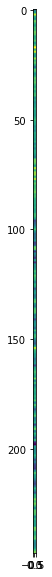

In [71]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(conv_logits[0].cpu().detach().numpy())

In [73]:
from torchmetrics import Accuracy

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)

In [79]:
N_EPOCHS = 10
print_every = 10
train_losses = []
steps = 0

for epoch in range(N_EPOCHS):
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    for inputs, labels in trainloader:
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        # print(inputs)
        # print(labels)

        # dummy_labels = F.one_hot(labels, num_classes=num_classes)
        steps += 1

        optimizer.zero_grad()
        visual_ft, outputs = TempConv.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        accuracy = Accuracy().to(device)
        epoch_acc += accuracy(outputs, labels)
        optimizer.step()
        epoch_loss += loss.item()

        # print(f"Out: {outputs[0]}; Label: {labels[0]}")
        # print(labels)

    # break
    print("Epoch: {} Loss: {}; Accuracy: {}".format(epoch, epoch_loss/len(trainloader), epoch_acc/len(trainloader)))

Epoch: 0 Loss: 5.509858015811805; Accuracy: 0.006234216969460249
Epoch: 1 Loss: 5.509790854020552; Accuracy: 0.0049715908244252205
Epoch: 2 Loss: 5.509722589242338; Accuracy: 0.005366161465644836
Epoch: 3 Loss: 5.509588400522868; Accuracy: 0.005681818351149559
Epoch: 4 Loss: 5.509384954818572; Accuracy: 0.006029040552675724
Epoch: 5 Loss: 5.5095454803620925; Accuracy: 0.0052083334885537624
Epoch: 6 Loss: 5.5098373336021345; Accuracy: 0.005523989908397198
Epoch: 7 Loss: 5.509988298319807; Accuracy: 0.005445075687021017
Epoch: 8 Loss: 5.509549742997295; Accuracy: 0.0052083334885537624
Epoch: 9 Loss: 5.509710740561437; Accuracy: 0.005523989908397198


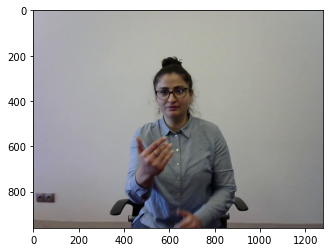

In [ ]:
file_path = "../data/cam2/1/2022-05-26 11-15-10.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = PIL.Image.fromarray(img)
plt.imshow(np.asarray(img))

In [ ]:
from modules.temp_conv import TemporalConv

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
model.eval().to(device)

/home/toghrul/anaconda3/envs/sign-lang/lib/python3.9/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA RTX A5000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A5000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
import torchvision.models as models
from modules.temp_conv import TemporalConv

In [ ]:
class SLRModel(nn.Model):
    def __init__(
        self, num_classes, c2d_type. conv_type, use_bn=False,
        hidden_size=1024, gloss_dict=None, loss_weights=None,
        weight_norm=True, share_classifier=True
    ):
    super(SLRModel, self).__init__()
    self.decoder = None
    self.loss = dict()
    self.criterion_init()
    self.num_classes = num_classes
    self.loss_weights = loss_weights
    self.conv2d = getattr(models, c2d_type)(pretrained=True)
    self.conv1d = TemporalConv(input_size=512,
                                   hidden_size=hidden_size,
                                   conv_type=conv_type,
                                   use_bn=use_bn,
                                   num_classes=num_classes)



    

SyntaxError: invalid syntax (3035282140.py, line 3)

In [ ]:
torch.cuda.device_count()

1

In [ ]:
import torchvision
import torch.optim as optim

In [ ]:
import os
import json
import cv2
import shutil

In [ ]:
gloss_df

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0
...,...,...,...,...,...,...
9108,ALMIŞAM,104.0,139.0,2022-07-27 11-53-28.mp4,249,35.0
9109,OĞUL,44.0,61.0,2022-07-27 11-53-28.mp4,249,17.0
9110,ÜÇÜN,64.0,78.0,2022-07-27 11-53-28.mp4,249,14.0
9111,HƏDİYYƏ,81.0,97.0,2022-07-27 11-53-28.mp4,249,16.0


In [ ]:
plt.hist(gloss_df[gloss_df.glossStart < 300]['glossStart'], bins=50)

NameError: name 'plt' is not defined

In [ ]:
gloss_df.loc[0, 'glossStart']

9.0

In [ ]:
cwd = os.path.dirname(os.path.abspath("tmp.ipynb"))
print(cwd)

/home/toghrul/SLR/sign-lang


In [ ]:
read_src = '../data/cam2'
write_src = '../data/gloss/'

In [ ]:
def video_to_frames(glossStart, glossEnd, video_path, size=None):
    """
    video_path -> str, path to video.
    size -> (int, int), width, height.
    """

    cap = cv2.VideoCapture(video_path)

    frames = []
    
    while True:
        res, frame = cap.read()
    
        if res:
            if size:
                frame = cv2.resize(frame, size)
            frames.append(frame)
        else:
            break

    cap.release()

    return frames[glossStart: glossEnd+1]

In [ ]:
def convert_frames_to_video(frames, path_out, size, fps=15):
    writer = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frames:
        # writing to a image array
        writer.write(frame)
    writer.release()

In [ ]:
for gloss, df in gloss_df.groupby(by='gloss'):
    for i in range(len(df)):
        
        df.reset_index(drop=True, inplace=True)
        video_path = os.path.join(read_src, str(df.loc[i, 'sentenceID']), df.loc[i, 'fileName'])
        
        if os.path.exists(video_path):
            write_path = path_out = os.path.join(write_src, gloss)
            if not os.path.exists(write_path):
                os.mkdir(write_path)

            path_out = os.path.join(write_path, df.loc[i,'fileName'])
            
            frames = video_to_frames(int(df.loc[i, 'glossStart']),
                                        int(df.loc[i, 'glossEnd']),
                                        video_path,
            )

            size = frames[0].shape[:2][::-1]
            convert_frames_to_video(frames, path_out, size, fps=15)
            
            if os.path.exists(path_out):
                print(f">>> Created: {path_out}")
            else:
                print("sth wrong")
                break


>>> Created: ../data/gloss/1/2022-08-01 13-56-29.mp4
>>> Created: ../data/gloss/1/2022-05-21 16-30-15.mp4
>>> Created: ../data/gloss/1/2022-07-16 11-27-36.mp4
>>> Created: ../data/gloss/1/2022-07-29 18-50-35.mp4
>>> Created: ../data/gloss/1/2022-07-22 10-56-20.mp4
>>> Created: ../data/gloss/1/2022-07-02 17-38-20.mp4
>>> Created: ../data/gloss/1/2022-07-19 11-45-02.mp4
>>> Created: ../data/gloss/1/2022-05-21 15-53-16.mp4
>>> Created: ../data/gloss/1/2022-05-26 11-27-26.mp4
>>> Created: ../data/gloss/1/2022-05-24 15-52-49.mp4
>>> Created: ../data/gloss/1/2022-07-18 12-28-36.mp4
>>> Created: ../data/gloss/1/2022-07-02 14-40-23.mp4
>>> Created: ../data/gloss/1/2022-07-15 14-54-47.mp4
>>> Created: ../data/gloss/1/2022-07-18 16-22-20.mp4
>>> Created: ../data/gloss/1/2022-07-20 16-24-03.mp4
>>> Created: ../data/gloss/1/2022-07-22 13-30-31.mp4
>>> Created: ../data/gloss/1/2022-06-13 12-53-52.mp4
>>> Created: ../data/gloss/1/2022-05-24 16-28-51.mp4
>>> Created: ../data/gloss/1/2022-04-26 13-05-

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_stats():
    res = collections.defaultdict(dict)
    for x in pretrainedmodels.model_names:
        try:
            m = pm.__dict__[x](num_classes=1000, pretrained='imagenet')
            num_params = get_n_params(m)
            name_last, layer = list(m._modules.items())[-1]
            res[x]['n_params'] = num_params
            res[x]['feature_l_name'] = name_last
            res[x]['model_out_size'] = layer.in_features
        except:
            print('err', x)
    return res

_models = {
    'squeezenet1_0': { 'n_params': 1248424, 'feature_l_name': 'last_conv'},
    'squeezenet1_1': {'n_params': 1235496, 'feature_l_name': 'last_conv'},

    'vgg11_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg13_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg16_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg19_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},

    'vgg11': { 'n_params': 132863336, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg13': {'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg16': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg19': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},

    'densenet121': { 'n_params': 7978856, 'feature_l_name': 'last_linear', 'model_out_size': 1024},
    'densenet161': {'n_params': 28681000, 'feature_l_name': 'last_linear', 'model_out_size': 2208},
    'densenet169':{ 'n_params': 14149480, 'feature_l_name': 'last_linear', 'model_out_size': 1664},
    'densenet201': { 'n_params': 20013928, 'feature_l_name': 'last_linear', 'model_out_size': 1920},


    'inceptionresnetv2': { 'n_params': 55843464, 'feature_l_name': 'last_linear', 'model_out_size': 1536},
    'inceptionv3': { 'n_params': 27161264, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'inceptionv4': { 'n_params': 42679816, 'feature_l_name': 'last_linear', 'model_out_size': 1536},
    'bninception': {'n_params': 11295240, 'feature_l_name': 'last_linear', 'model_out_size': 1024},
    'xception': { 'n_params': 22855952, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'dpn68': { 'n_params': 12611602, 'feature_l_name': 'classifier'},
    'dpn98': { 'n_params': 61570728, 'feature_l_name': 'classifier'},
    'dpn131': {'n_params': 79254504, 'feature_l_name': 'classifier'},

    'alexnet': { 'n_params': 61100840, 'feature_l_name': 'last_linear', 'model_out_size': 4096},

    'resnet18': { 'n_params': 11689512, 'feature_l_name': 'last_linear', 'model_out_size': 512},
    'resnet34': {'n_params': 21797672, 'feature_l_name': 'last_linear', 'model_out_size': 512},
    'resnet50': {'n_params': 25557032, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'resnet101': { 'n_params': 44549160, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'resnet152': { 'n_params': 60192808, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'resnext101_32x4d': { 'n_params': 44177704, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'resnext101_64x4d': { 'n_params': 83455272, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'senet154': { 'n_params': 115088984, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'fbresnet152': {'n_params': 60268520, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'se_resnet50': { 'n_params': 28088024, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'se_resnet101': { 'n_params': 49326872, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'se_resnet152': { 'n_params': 66821848, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'se_resnext50_32x4d': { 'n_params': 27559896, 'feature_l_name': 'last_linear',  'model_out_size': 2048},
    'se_resnext101_32x4d': {'n_params': 48955416, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'nasnetalarge': {'n_params': 88753150, 'feature_l_name': 'last_linear', 'model_out_size': 4032},
    'nasnetamobile': {'n_params': 5289978, 'feature_l_name': 'last_linear', 'model_out_size': 1056},
}

In [40]:
# model = nn.Sequential()
# model.add_module('W0', nn.Linear(8, 16))
# model.add_module('tanh', nn.Tanh())
# model.add_module('W1', nn.Linear(16, 1))

# x = torch.randn(1, 8)
# y = model(x)

# torchviz.make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

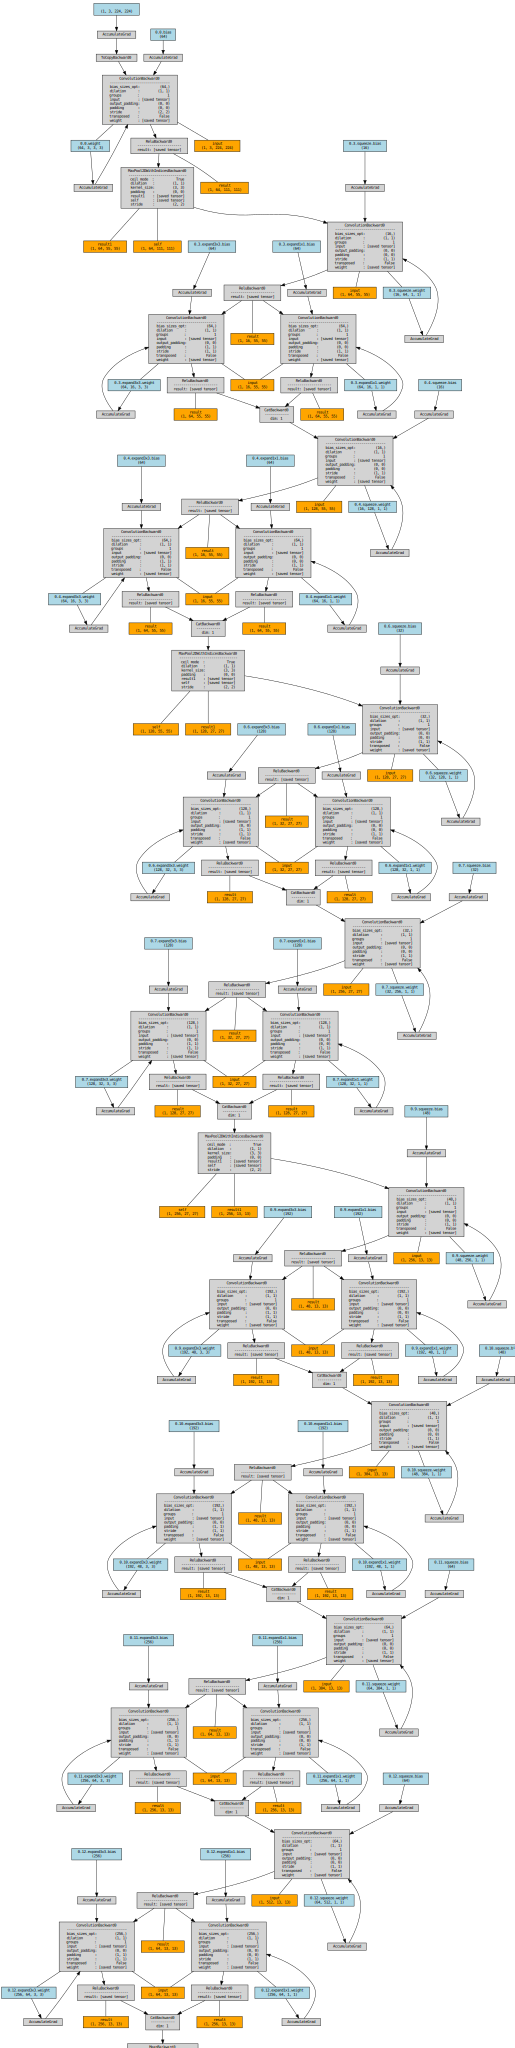

In [44]:
x = torch.randn(1, 3, 224, 224).requires_grad_(True).to(device)
y = my_model(x)

torchviz.make_dot(y.mean(), params=dict(my_model.named_parameters()), show_attrs=True, show_saved=True)